In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import statistics
from wordcloud import WordCloud, STOPWORDS
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import LabelPowerset
from sklearn import svm
from skmultilearn.problem_transform import BinaryRelevance

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
# open and view CMU books dataset
CMU = pd.read_csv("booksummaries.csv")
CMU.head()

,Wikipedia ID,Freebase ID,Book title,Book author,Publication date,Genres,Plot summary
0,620,/m/0hhy,Animal Farm,George Orwell,17/08/1945,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,"The argument of the Enquiry proceeds by a series of incremental steps, separated into chapters which logically succeed one another. After expounding his epistemology, Hume explains how to apply his principles to specific topics. In the first section of the Enquiry, Hume provides a rough introdu..."
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""Speculative fiction"", ""/m/01hmnh"": ""Fantasy"", ""/m/02xlf"": ""Fiction""}","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."


In [3]:
CMU.shape

(16566, 7)

In [4]:
# remove unneeded columns
CMU=CMU.drop(['Wikipedia ID', 'Freebase ID', 'Publication date'], axis=1)
CMU=CMU.rename(columns={"Book title": "title", "Book author": "author", "Genres":"genres", "Plot summary":"summary"})

In [5]:
# remove books with missing values
CMU=CMU.dropna()

In [6]:
# extract genres from JSON format into lists 
CMU['genres'] = CMU['genres'].map(lambda x: list(json.loads(x).values()))

In [7]:
# re-order columns
columns_titles = ['title','author', 'genres', 'summary']
CMU=CMU.reindex(columns=columns_titles)

In [8]:
# save new dataframe as csv
# CMU.to_csv(r'/Users/yanngo/Dropbox/Uni work/Independent Research Project/new_cmu.csv', index = False)
CMU

,title,author,genres,summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, Novel]","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
4,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
...,...,...,...,...
16556,The Third Lynx,Timothy Zahn,[Science Fiction],"The story starts with former government agent, Frank Compton, meeting a young man who drops dead at his feet. Compton finds a ticket to a strange, interstellar train called the Quadrail. During Compton's ride on the Quadrail he falls asleep, and wakes up in the custody of the spiders, the opera..."
16558,Remote Control,Andy McNab,"[Thriller, Fiction, Suspense]","The series follows the character of Nick Stone, an ex-military man who previously worked for the SAS, British Intelligence, and an American agency. Stone now works as a paid mercenary, willing to work in even the most difficult circumstances. The series has Stone dealing with assassination, pol..."
16562,Transfer of Power,Vince Flynn,"[Thriller, Fiction]","The reader first meets Rapp while he is doing a covert operation in Iran and he discovers a possible terrorist attack planned for the nations capital to happen in the near future. Meanwhile in Washington, D.C., Anna Reilly is starting her first day as a White House correspondent for NBC. It als..."
16563,Decoded,Jay-Z,[Autobiography],"The book follows very rough chronological order, while switching from current stories to his story of growing up in the Marcy projects. The autobiographical portion focuses on not only his story of drug dealing, fights, and the beginnings in rap, but also his reflections on those times in his l..."


In [9]:
def show_genres_frequency_chart(genres_series):
    list_genres = sum(genres_series,[])

    list_genres = nltk.FreqDist(list_genres) 

    # create dataframe
    list_genres_df = pd.DataFrame({'Genre': list(list_genres.keys()), 
                                  'Count': list(list_genres.values())})

    graph = list_genres_df.nlargest(columns="Count", n = 50) 
    plt.figure(figsize=(12,15)) 
    axis = sns.barplot(data=graph, x= "Count", y = "Genre") 
    axis.set(ylabel = 'Count') 
    plt.show()
    
    return list_genres_df

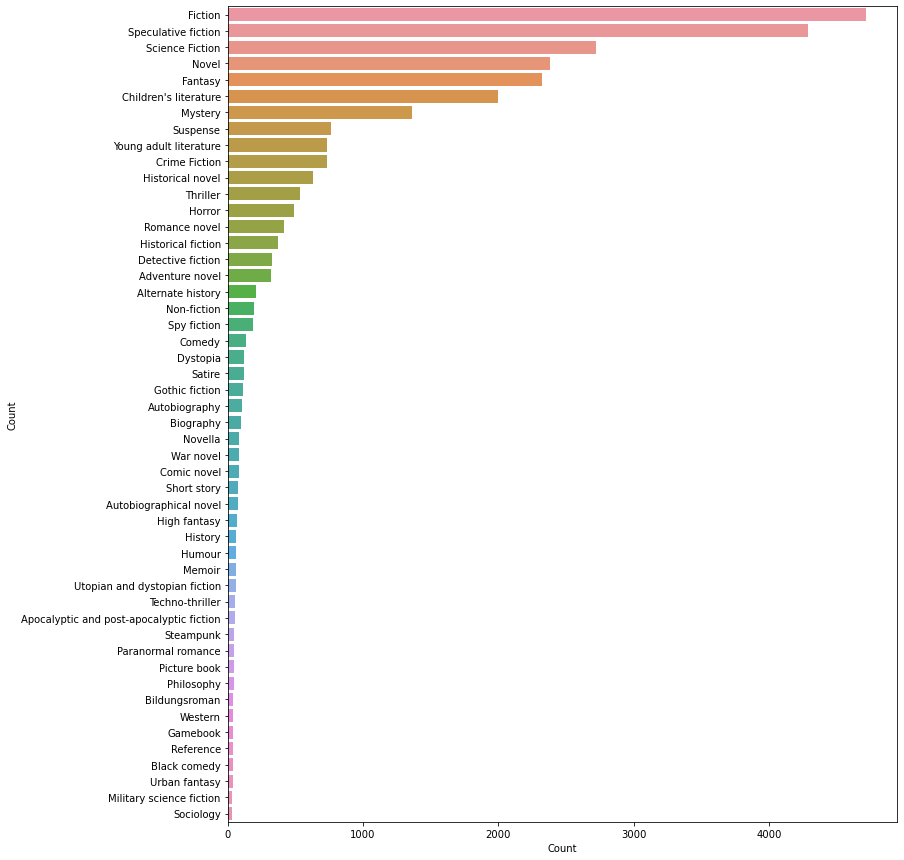

In [10]:
cmu_genres_count_df = show_genres_frequency_chart(CMU.genres)

In [11]:
# all genres in CMU dataset
cmu_genres_count_df['Genre'].unique()

array(['Roman à clef', 'Satire', "Children's literature",
       'Speculative fiction', 'Fiction', 'Science Fiction', 'Novella',
       'Utopian and dystopian fiction', 'Existentialism',
       'Absurdist fiction', 'Novel', 'Hard science fiction', 'Fantasy',
       'War novel', 'Bildungsroman', 'Picaresque novel', 'Gothic fiction',
       'Horror', 'Invasion literature', 'Mystery', 'Epistolary novel',
       'Parody', 'Psychological novel', 'Farce', 'Philosophy', 'Science',
       'Dystopia', 'Detective fiction', 'Suspense', 'Historical fiction',
       'Adventure novel', 'Humour', 'Historical novel', 'Sea story',
       'Cyberpunk', 'Business', 'Non-fiction', 'Economics',
       'Anthropology', 'Sociology', 'Romance novel', 'Poetry',
       'Chivalric romance', 'High fantasy', 'Time travel',
       'Scientific romance', 'Crime Fiction', 'Juvenile fantasy',
       'Religion', 'Inspirational', 'Short story', 'Techno-thriller',
       'Thriller', 'Young adult literature', 'Drama', 'Play'

In [12]:
# map genres to list of genres that it should become
# if the genre is not present then it is removed
genres_conversion = {
    'alien invasion': ['science fiction'],
    'roman à clef': ['biography and autobiography'],
    'satire': ['comedy'],
    'war novel': ['war'],
    'fiction': [],
    'romance': ['romance'],
    'science fiction': ['science fiction'],
    "Children's literature": ["Children's literature"],
    'Speculative fiction': ['Speculative fiction'],
    'Utopian and dystopian fiction':['Utopian and dystopian fiction'],
    'Hard science fiction':['science fiction'],
    'Fantasy': ['Fantasy'], 
    # TODO the rest
}
def transform_genres(genres):
    
    # lowercase all genres
    lowercase_genres = [genre.lower() for genre in genres]
    
    # convert genres
    converted_genres = []
    for genre in lowercase_genres:
        if genre in genres_conversion:
            # add the converted genres
            converted_genres.extend(genres_conversion[genre])
    
    # TODO remove duplicate genres from list
    
    return converted_genres

In [47]:
CMU['genres'] = CMU['genres'].apply(transform_genres)
CMU

,title,author,genres,summary
0,Animal Farm,George Orwell,"[biography and autobiography, comedy]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[science fiction, comedy]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,The Plague,Albert Camus,[],"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
4,A Fire Upon the Deep,Vernor Vinge,[science fiction],"The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,"[war, biography and autobiography]","The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
...,...,...,...,...
16556,The Third Lynx,Timothy Zahn,[science fiction],"The story starts with former government agent, Frank Compton, meeting a young man who drops dead at his feet. Compton finds a ticket to a strange, interstellar train called the Quadrail. During Compton's ride on the Quadrail he falls asleep, and wakes up in the custody of the spiders, the opera..."
16558,Remote Control,Andy McNab,[],"The series follows the character of Nick Stone, an ex-military man who previously worked for the SAS, British Intelligence, and an American agency. Stone now works as a paid mercenary, willing to work in even the most difficult circumstances. The series has Stone dealing with assassination, pol..."
16562,Transfer of Power,Vince Flynn,[],"The reader first meets Rapp while he is doing a covert operation in Iran and he discovers a possible terrorist attack planned for the nations capital to happen in the near future. Meanwhile in Washington, D.C., Anna Reilly is starting her first day as a White House correspondent for NBC. It als..."
16563,Decoded,Jay-Z,[],"The book follows very rough chronological order, while switching from current stories to his story of growing up in the Marcy projects. The autobiographical portion focuses on not only his story of drug dealing, fights, and the beginnings in rap, but also his reflections on those times in his l..."


In [14]:
# removing books with no genres
CMU = CMU[CMU['genres'].map(lambda d: len(d)) > 0]
CMU

,title,author,genres,summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, Novel]","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
4,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
...,...,...,...,...
16556,The Third Lynx,Timothy Zahn,[Science Fiction],"The story starts with former government agent, Frank Compton, meeting a young man who drops dead at his feet. Compton finds a ticket to a strange, interstellar train called the Quadrail. During Compton's ride on the Quadrail he falls asleep, and wakes up in the custody of the spiders, the opera..."
16558,Remote Control,Andy McNab,"[Thriller, Fiction, Suspense]","The series follows the character of Nick Stone, an ex-military man who previously worked for the SAS, British Intelligence, and an American agency. Stone now works as a paid mercenary, willing to work in even the most difficult circumstances. The series has Stone dealing with assassination, pol..."
16562,Transfer of Power,Vince Flynn,"[Thriller, Fiction]","The reader first meets Rapp while he is doing a covert operation in Iran and he discovers a possible terrorist attack planned for the nations capital to happen in the near future. Meanwhile in Washington, D.C., Anna Reilly is starting her first day as a White House correspondent for NBC. It als..."
16563,Decoded,Jay-Z,[Autobiography],"The book follows very rough chronological order, while switching from current stories to his story of growing up in the Marcy projects. The autobiographical portion focuses on not only his story of drug dealing, fights, and the beginnings in rap, but also his reflections on those times in his l..."


In [15]:
CMU.shape

(12055, 4)

In [16]:
# open and view OL and GB dataset 
OLGB = pd.read_csv("books.csv")
OLGB.head()

,gb_query,gb_title,gb_authors,gb_description,gb_categories,olb_subjects_isbn13,olb_subjects_isbn10
0,subject:science fiction,"Your Day, Your Way",Timothy Caulfield,"Part pop-science, part self-help, Your Day. Your Way. is a friendly, funny, fact-based guide to changing how you make decisions in order to live a better -- maybe even your best -- life. We make, and worry about, a thousand big and little decisions during our waking hours. And for most of us, th...",Science,NaN,NaN
1,subject:science fiction,Appraisal,NaN,NaN,Science,NaN,NaN
2,subject:science fiction,Science Fiction,Terence Kealey,NaN,Great Britain,Science -- Great Britain.,Science -- Great Britain.
3,subject:science fiction,Archangel: Fiction,Andrea Barrett,"A 12-year-old boy discovers the wonders of science and the natural world from motorized bicycles, to airplanes, to x-ray technology and genetics in this collection of five stories by the National Book Award-winning author of Ship Fever. 30,000 first printing.",Fiction,Science|Fiction|History,Science|Fiction|History
4,subject:science fiction,Science Reporter,NaN,NaN,Science,NaN,NaN


In [17]:
OLGB.shape

(2384, 7)

In [18]:
# remove books with no description
OLGB.dropna(subset = ["gb_description"], inplace=True)

In [19]:
# change all NaN values to 'UNKNOWN'
OLGB= OLGB.fillna('UNKNOWN')

In [20]:
# combine categories, queries and subjects to make a genres column
OLGB['genres']=OLGB['gb_categories'].astype(str)+'|'+OLGB['olb_subjects_isbn13']+'|'+OLGB['olb_subjects_isbn10']

In [21]:
# remove unneeded columns
OLGB=OLGB.drop(['gb_query', 'gb_categories', 'olb_subjects_isbn13', 'olb_subjects_isbn10'], axis=1)
OLGB=OLGB.rename(columns={"gb_title": "title", "gb_authors": "author", "gb_description":"summary"})

In [22]:
# rename and re-order columns
columns_titles = ['title','author', 'genres', 'summary']
OLGB=OLGB.reindex(columns=columns_titles)

In [23]:
# removing / from genres
OLGB['genres'] = OLGB['genres'].map(lambda x: x.replace("/", "|"))

In [24]:
# clean genres
OLGB["genres"] = OLGB["genres"].str.lower()
OLGB['genres'] = OLGB['genres'].map(lambda x: list(x.split("|")))

In [25]:
OLGB

,title,author,genres,summary
0,"Your Day, Your Way",Timothy Caulfield,"[science, unknown, unknown]","Part pop-science, part self-help, Your Day. Your Way. is a friendly, funny, fact-based guide to changing how you make decisions in order to live a better -- maybe even your best -- life. We make, and worry about, a thousand big and little decisions during our waking hours. And for most of us, th..."
3,Archangel: Fiction,Andrea Barrett,"[fiction, science, fiction, history, science, fiction, history]","A 12-year-old boy discovers the wonders of science and the natural world from motorized bicycles, to airplanes, to x-ray technology and genetics in this collection of five stories by the National Book Award-winning author of Ship Fever. 30,000 first printing."
7,"Alien Life ,From Science Fiction to Science Fact",Joseph Angelo,"[astronomy, unknown, unknown]","Designed to help students and teachers better appreciate science and engineering in a global context, this eBook gives a brief history of humanity's fascination with space going back to prehistory and shows how space travel bec."
9,Practising Science Communication in the Information Age,Richard Holliman|Jeff Thomas|Sam Smidt|Eileen Scanlon|Elizabeth Whitelegg,"[language arts & disciplines, unknown, unknown]","Practising science communication in the information age reviews the trends and issues that are engaging practitioners of science communication, critically exploring topics as diverse as peer review, open access publication, the protection of intellectual property, the popularisation of science, ..."
11,The Screenwriter's Handbook 2009,B. Turner,"[juvenile nonfiction, unknown, unknown]","""This is the essential guide for all aspiring, new and established writers for the screen. It includes hundreds of useful contact detail entries from courses, societies and grants to representation and production companies.""--Provided by publisher."
...,...,...,...,...
2379,The Giants and the Joneses,Julia Donaldson,"[juvenile fiction, unknown, unknown]","When Jumbeelia, an eight-year-old giant, climbs down a beanstalk and collects some ""iggly plops,"" the little people of children's stories, she treats them like toys, unaware that she is endangering their lives."
2380,Girl on a Wire,Gwenda Bond,"[juvenile fiction, teenage girls, juvenile fiction, circus, girls, teenagers, fiction, fantasy, aerialists, mystery fiction, teenage girls, juvenile fiction, circus, girls, teenagers, fiction, fantasy, aerialists, mystery fiction]","Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
2381,The Riverman,Aaron Starmer,"[juvenile fiction, fantasy, juvenile fiction , social themes , friendship, juvenile fiction, friendship, juvenile fiction , fantasy & magic, fiction, fantasy, juvenile fiction , social themes , friendship, juvenile fiction, friendship, juvenile fiction , fantasy & magic, fiction]","""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
2382,The Lord of Castle Black,Steven Brust,"[fiction, fantasy - general, fiction, fiction - fantasy, fantasy, action & adventure, fantasy - epic, fiction , fantasy , epic, fantasy - general, fiction, fiction - fantasy, fantasy, action & adventure, fantasy - epic, fiction , fantasy , epic]","The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


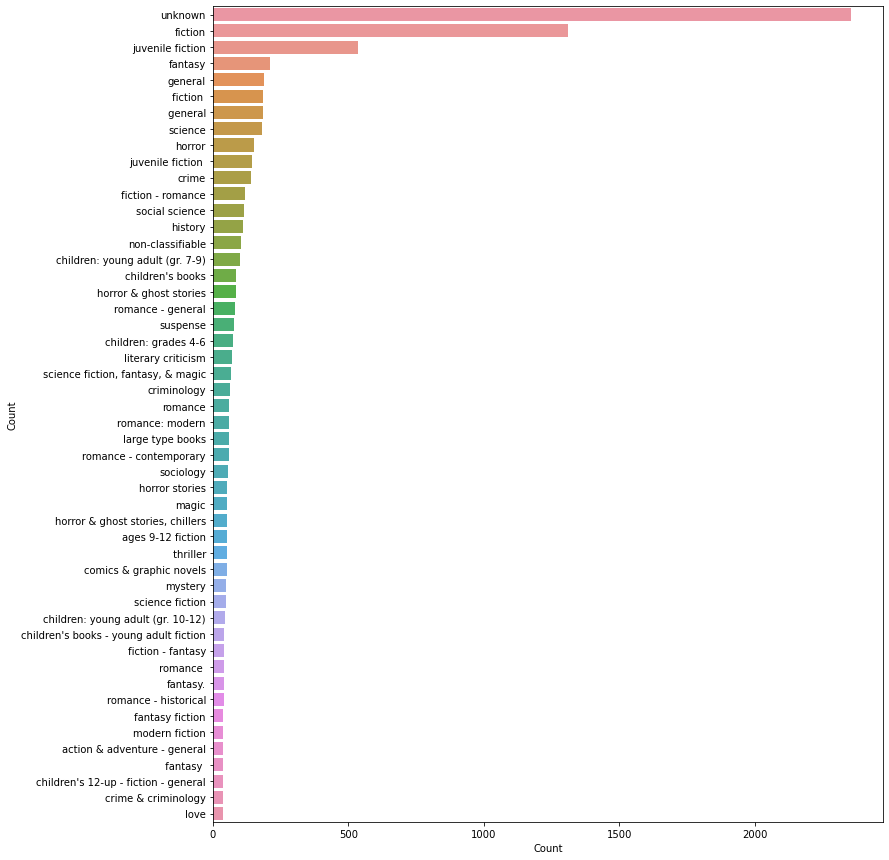

In [26]:
olgb_genres_count_df = show_genres_frequency_chart(OLGB.genres)

In [27]:
len(olgb_genres_count_df['Genre'].unique())

1925

In [28]:
# removing irrelevant genres
OLGB['genres'] = OLGB['genres'].apply(transform_genres)
OLGB

,title,author,genres,summary
0,"Your Day, Your Way",Timothy Caulfield,[],"Part pop-science, part self-help, Your Day. Your Way. is a friendly, funny, fact-based guide to changing how you make decisions in order to live a better -- maybe even your best -- life. We make, and worry about, a thousand big and little decisions during our waking hours. And for most of us, th..."
3,Archangel: Fiction,Andrea Barrett,[],"A 12-year-old boy discovers the wonders of science and the natural world from motorized bicycles, to airplanes, to x-ray technology and genetics in this collection of five stories by the National Book Award-winning author of Ship Fever. 30,000 first printing."
7,"Alien Life ,From Science Fiction to Science Fact",Joseph Angelo,[],"Designed to help students and teachers better appreciate science and engineering in a global context, this eBook gives a brief history of humanity's fascination with space going back to prehistory and shows how space travel bec."
9,Practising Science Communication in the Information Age,Richard Holliman|Jeff Thomas|Sam Smidt|Eileen Scanlon|Elizabeth Whitelegg,[],"Practising science communication in the information age reviews the trends and issues that are engaging practitioners of science communication, critically exploring topics as diverse as peer review, open access publication, the protection of intellectual property, the popularisation of science, ..."
11,The Screenwriter's Handbook 2009,B. Turner,[],"""This is the essential guide for all aspiring, new and established writers for the screen. It includes hundreds of useful contact detail entries from courses, societies and grants to representation and production companies.""--Provided by publisher."
...,...,...,...,...
2379,The Giants and the Joneses,Julia Donaldson,[],"When Jumbeelia, an eight-year-old giant, climbs down a beanstalk and collects some ""iggly plops,"" the little people of children's stories, she treats them like toys, unaware that she is endangering their lives."
2380,Girl on a Wire,Gwenda Bond,[],"Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
2381,The Riverman,Aaron Starmer,[],"""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
2382,The Lord of Castle Black,Steven Brust,[],"The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


In [29]:
# removing books with no genres
OLGB=OLGB[OLGB['genres'].map(lambda d: len(d)) > 0]

In [30]:
# function to remove duplicate genres
def duplicate_genres(x):
  return list(dict.fromkeys(x))

OLGB['genres'] = OLGB['genres'].apply(duplicate_genres)
OLGB

<ipython-input-30-3ecfa8d47d6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OLGB['genres'] = OLGB['genres'].apply(duplicate_genres)


,title,author,genres,summary
44,Time Machines,Bill Adler,[science fiction],Time Machines is a mind-bending collection o f time-travel tales from popular and science fiction writers . It is one of the most fluid forms of storytelling and cros ses over between science fiction and literary fiction. '
119,Love's Mistakes,Kay Gregory,[romance],"When newly-widowed Zinnia Marsh returns to her childhood home, she knows it is possible she'll encounter Jonathan Monroe, who she had idolised as a teenager. What she doesn't anticipate is that Jonathan will end up delivering her baby! A confirmed bachelor, Jonathan is even more surprised - and ..."
120,The Marriage Inheritance,Michelle Styles,[romance],"When Caroline Adams arrives at Rafe Worthington's Northumberland castle, she finds her holiday cottage is uninhabitable. Rafe offers her accomodation in return for playing his fiancee, to foil his scheming cousin Jenna's plans for the castle. Caroline agrees, but then she confesses all to Rafe's..."
125,Roses in the Night,Kay Gregory,[romance],"Clayte O'Neill was determined to come up with the perfect romantic gesture, but Georgina was equally determined not to be impressed! Clayte might be wickedly handsome but, as a dynamic tycoon, he was arrogantly self-assured and used to calling all the shots! He was also Georgina's new boss, whic..."
138,Plantagenet Princess,Hilda Brookman Stanier,[romance],"Elizabeth of York is a controversial figure. Did she or did she not love her Uncle Richard? What was the relationship between herself and Margaret Beaufort, her mother-in-law? How much affection did Henry VII have for the niece of the man whose throne he had usurped by right of conquest?"
144,The Master of Monkton Manor,Valerie Holmes,[romance],"Homeless, Megan Clegg is forced to take up a position as lady's maid in Manor House, the home of Lady Mary Jarvis and her son, Samuel, who runs the estate. But soon Megan begins to suspect that behind the manor's dignified exterior something sinister is going on. It is only when a young boy is f..."
208,Celestial Debris,Lawrence Watt-Evans,[science fiction],A new collection of short stories by Hugo Winner Lawrence Watt-Evans
223,The Terminator,James Robinson|Alan Grant|Toren Smith|Chris Warner|Adam Warren|Matt Wagner|Guy (ART) Davis|Bill (ART) Jaaska,[science fiction],"In a trio of futuristic illustrated Terminator tales, Kyle Reese is sent back in time to protect Sarah Connor from a female Terminator, bounty hunter Van Dirk holds the key to protecting John Connor from a pair of ruthless Terminators, and in the twenty-first century, Skynet and its Terminators ..."
363,Voodoo Moon,Wendy Corsi Staub|Constance M. Burge,[science fiction],"If her soul is bound by an evil spell, Call back her spirit with a ringing bell. Salt in her left hand, gold in her right Will cast out the dark and restore her soul's light. The Halliwells are on vacation. It's time to party in New Orleans. But on Prue, Piper, and Phoebe's first night in the Bi..."
370,Alien Harvest,Robert Sheckley,[science fiction],"Down-and-out scientist Stan Myakovsky dodges spaceship repo men and dreams of marketing his cybernetic ant, until a beautiful and mysterious woman enters his life"


In [31]:
OLGB.shape

(59, 4)

In [32]:
# concatenate both datasets
frames = [CMU, OLGB]
books = pd.concat(frames)
books

,title,author,genres,summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, Novel]","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
4,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
...,...,...,...,...
2331,Breathless,Kimberly Raye,[romance],"Breathless by Kimberly Raye released on Feb 22, 1999 is available now for purchase."
2334,I'll Be Home for Christmas,Lenora Worth,[romance],"I'll Be Home For Christmas by Lenora Worth released on Sep 24, 1998 is available now for purchase."
2339,Crazy for You,Codi Gary,[romance],"Disaster Deana can't catch a break... Deana Sawyer has always been cursed. Even when she tries to change her image, she ends up with hot pink hair and a Halloween costume that's about to have a wardrobe malfunction. To make matters worse, the guy who broke her heart in high school is back in Loc..."
2356,Doom of the Darksword,Margaret Weis,[science fiction],"Henry is generally well-behaved, but he is occasionally arrogant and vain. Henry is at heart a hard worker, but his frequent bouts of illness hinder his work."


In [33]:
# save as new dataframe as csv
# books.to_csv(r'/Users/yanngo/Dropbox/Uni work/Independent Research Project/cleaned_books.csv', index = False)

In [34]:
# after manually deleting 64 books with irrelevant summaries such as 'to be added later' using excel,
# the csv was saved and reopened 
books = pd.read_csv("cleaned_books.csv")
books

,title,author,genres,summary
0,Animal Farm,George Orwell,"['satire', ""children's literature"", 'speculative fiction']","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"['science fiction', 'speculative fiction', 'utopian and dystopian fiction', 'satire']","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,A Fire Upon the Deep,Vernor Vinge,"['science fiction', 'speculative fiction', 'fantasy']","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
3,All Quiet on the Western Front,Erich Maria Remarque,['war novel'],"The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
4,A Wizard of Earthsea,Ursula K. Le Guin,"[""children's literature"", 'fantasy', 'speculative fiction']","Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis..."
...,...,...,...,...
9368,Anna & Elsa #4: The Great Ice Engine (Disney Frozen),Erica David,['fantasy'],"A new chapter book series featuring the stars of Disney's Frozen finds Elsa using her magical powers over ice and snow, and Anna following her own adventurous, loving spirit to explore their home and kingdom. Movie tie-in."
9369,Girl on a Wire,Gwenda Bond,['fantasy'],"Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
9370,The Riverman,Aaron Starmer,['fantasy'],"""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
9371,The Lord of Castle Black,Steven Brust,['fantasy'],"The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


In [35]:
books['genres'] = books.genres.apply(lambda x: literal_eval(str(x)))

In [36]:
# get all genre tags in a list
all_genres = sum(books.genres,[])
len(set(all_genres))

21

In [37]:
# create a dictionary of genres and their occurrences 
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
all_genres_df

,Genre,Count
0,satire,117
1,children's literature,2002
2,speculative fiction,4292
3,science fiction,2749
4,utopian and dystopian fiction,57
5,fantasy,2439
6,war novel,85
7,horror,582
8,mystery,1383
9,dystopia,118


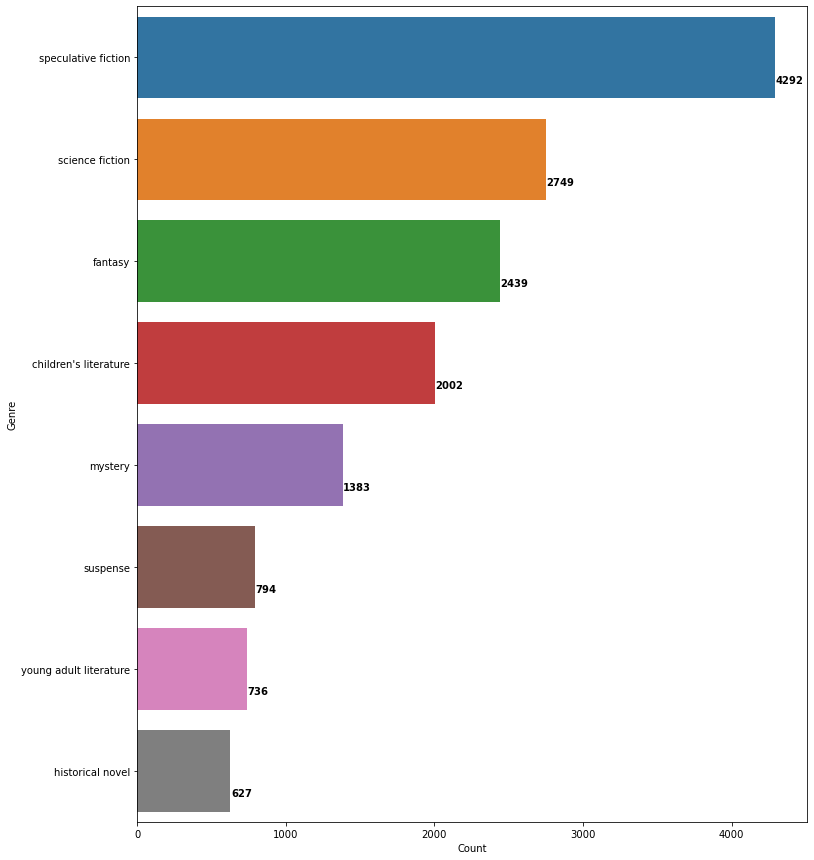

In [38]:
# plot the distribution of the book genres
g = all_genres_df.nlargest(columns="Count", n = 8) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
for i, v in enumerate(g['Count']):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
    
plt.show()

In [39]:
# make a mean number of genres column
books['genres_count'] = books['genres'].map(lambda genres_list: len(genres_list))
books

,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"[satire, children's literature, speculative fiction]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p...",3
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction, utopian and dystopian fiction, satire]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and...",4
2,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti...",3
3,All Quiet on the Western Front,Erich Maria Remarque,[war novel],"The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me...",1
4,A Wizard of Earthsea,Ursula K. Le Guin,"[children's literature, fantasy, speculative fiction]","Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis...",3
...,...,...,...,...,...
9368,Anna & Elsa #4: The Great Ice Engine (Disney Frozen),Erica David,[fantasy],"A new chapter book series featuring the stars of Disney's Frozen finds Elsa using her magical powers over ice and snow, and Anna following her own adventurous, loving spirit to explore their home and kingdom. Movie tie-in.",1
9369,Girl on a Wire,Gwenda Bond,[fantasy],"Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally.",1
9370,The Riverman,Aaron Starmer,[fantasy],"""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--",1
9371,The Lord of Castle Black,Steven Brust,[fantasy],"The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne.",1


In [40]:
mean = books.genres_count.mean()
median = books.genres_count.median()
mode = books.genres_count.mode()

In [41]:
mean

1.8523418329243573

In [42]:
median

2.0

In [43]:
mode

0    1
dtype: int64

In [44]:
every_genre = books['genres']
every_genre

0                                [satire, children's literature, speculative fiction]
1       [science fiction, speculative fiction, utopian and dystopian fiction, satire]
2                                     [science fiction, speculative fiction, fantasy]
3                                                                         [war novel]
4                               [children's literature, fantasy, speculative fiction]
                                            ...                                      
9368                                                                        [fantasy]
9369                                                                        [fantasy]
9370                                                                        [fantasy]
9371                                                                        [fantasy]
9372                                                                        [fantasy]
Name: genres, Length: 9373, dtype: object

In [45]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", str(text)) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [46]:
# apply the function on the book summaries
books['summary'] = books['summary'].apply(lambda x: clean_text(x))
books

NameError: name 're' is not defined

In [ ]:
# Iterating through the summary column 
books_summaries = ''

for i in books.summary: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    books_summaries += " ".join(separate)+" "

In [ ]:
# Creating Word Clouds
def show_word_cloud(genre):
    genre_books = books[books.genres.apply(lambda genres_list: genre in genres_list)]
    final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(books_summaries)    
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(final_wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
# science fiction word cloud 
show_word_cloud('science fiction')

In [ ]:
# crime word cloud 
show_word_cloud('crime')

In [ ]:
# mystery word cloud 
show_word_cloud('mystery')

In [ ]:
# horror word cloud 
show_word_cloud('horror')

In [ ]:
# thriller word cloud 
show_word_cloud('thriller')

In [ ]:
# suspense word cloud 
show_word_cloud('suspense')

In [ ]:
# fantasy word cloud 
show_word_cloud('fantasy')

In [ ]:
# romance word cloud 
show_word_cloud('romance')

In [ ]:
# visualise most frequent words in the summaries column
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(books['summary'], 100)

In [ ]:
# remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['summary'] = books['summary'].apply(lambda x: remove_stopwords(x))

In [ ]:
# most frequent words minus stopwords
freq_words(books['summary'], 100)

In [ ]:
# Use sklearn’s MultiLabelBinarizer( ) to turn this multi-label classification problem into a Binary Relevance problem

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(books['genres'])

# transform target variable
y = multilabel_binarizer.transform(books['genres'])

In [ ]:
# extract features from the cleaned book summaries using TF-IDF with the 10,000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [ ]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(books['summary'], y, test_size=0.2, random_state=9)

In [ ]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

In [ ]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [ ]:
y_pred[3]

In [ ]:
multilabel_binarizer.inverse_transform(y_pred)[3]

In [ ]:
f1_score(yval, y_pred, average="micro")

In [ ]:
# using binary relevance with NB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier1 = BinaryRelevance(GaussianNB())

# train
classifier.fit(xtrain_tfidf, ytrain)

# predict
predictions3 = classifier1.predict(xval_tfidf)
f1_score(yval, predictions3, average="micro")

In [ ]:

def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Book: ", books['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",books['genres'][k], "\n")


In [ ]:
# using classifier chains
# initialize classifier chains multi-label classifier
classifier2 = ClassifierChain(GaussianNB())
# Training logistic regression model on train data
classifier2.fit(xtrain_tfidf, ytrain)
# predict
predictions1 = classifier2.predict(xval_tfidf)
# accuracy
#print("Accuracy = ",accuracy_score(yval,predictions))
#print("\n")
f1_score(yval, predictions1, average="micro")

In [ ]:
# using Label Powerset
# initialize label powerset multi-label classifier
classifier3 = LabelPowerset(svm.SVC())
# train
classifier.fit(xtrain_tfidf, ytrain)
# predict
predictions2 = classifier3.predict(xval_tfidf)
# accuracy
#print("Accuracy = ",accuracy_score(y_test,predictions))
#print("\n")
f1_score(yval, predictions2, average="micro")